In [51]:
import utils
import qiskit
import qiskit_aer
import numpy as np
from math import log
import qiskit.visualization
import matplotlib.pyplot as plt

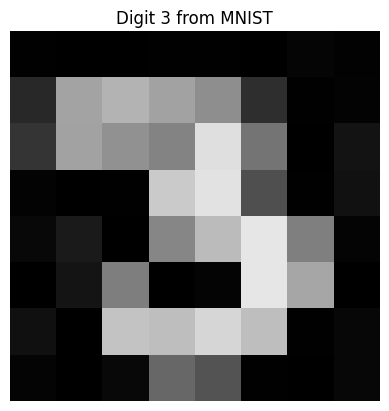

In [52]:
image = utils.plot_image('images/three_8by8.jpg', 'Digit 3 from MNIST')

In [53]:
def equal_superposition(circ: qiskit.QuantumCircuit, start: int, end: int):
    for idx in range(start, end): 
        circ.h(idx)
        
def iterate(circ: qiskit.QuantumCircuit, padding: int, current_state: str, next_state: str):
    n = len(current_state)
    
    # Indices we must apply an X gate to go from current_state to next_state 
    #   - We reverse the state strings because we set the coordinates qubits in the circuit
    #       in descending order.
    x_targets = np.array([idx + padding for idx in range(n) 
                          if current_state[::-1][idx] != next_state[::-1][idx]])

    # Example
    # 1110 -> 1111
    #   if we don't reverse the strings we get:
    #   x_targets = [3]
    #   thus we will apply the X gate on the fourth qubit.
    #   but this is not what we want, we should apply it to the first qubit.
    #   think little endian vs big endian
    
    if x_targets.size > 0:
        circ.x(x_targets)

def pixel_encoding(circ: qiskit.QuantumCircuit, control: list, intensity: str):
    for idx, val in enumerate(intensity[::-1]):
        if int(val):
            circ.mcx(control_qubits=control,
                     target_qubit=idx)
            
    

In [54]:
def construct_neqr(circ: qiskit.QuantumCircuit, image: np.array):
    num_qubits = circ.num_qubits
    num_intensity_qubits = 8       # 2^8 = 256
    num_idx_qubits = num_qubits - 8
    
    control = list(range(num_intensity_qubits, num_qubits)) 
    
    flat_img = image.flatten()
    num_pixels = len(flat_img)
    
    # Hadamard on index qubits.
    equal_superposition(circ, num_intensity_qubits, num_qubits)

    for idx, pixel in enumerate(flat_img):
        pixel_val = '{0:0{1}b}'.format(pixel, num_intensity_qubits) 
        state = '{0:0{1}b}'.format(idx-1, num_idx_qubits) 
        next_state = '{0:0{1}b}'.format(idx, num_idx_qubits) 
        
        if idx < num_pixels and idx > 0:
            iterate(circ, num_intensity_qubits, state, next_state) 
        pixel_encoding(circ, control, pixel_val)
        


        circ.barrier()   
    
    to_measure = [*range(num_qubits)]
    circ.measure(to_measure, to_measure)    

In [55]:
flat_ang_rep = utils.get_angle_representation(image,
                                                min_val=0,
                                                max_val=255)

n = int(log(image.shape[0], 2))

idx_reg = qiskit.QuantumRegister(2 * n, 'Index')
intensity_reg = qiskit.QuantumRegister(8, "Intensity") # Color intensity 2^8 -> (0, 255)
creg = qiskit.ClassicalRegister(2 * n + 8, 'bits')
neqr_circuit = qiskit.QuantumCircuit(intensity_reg, idx_reg, creg)

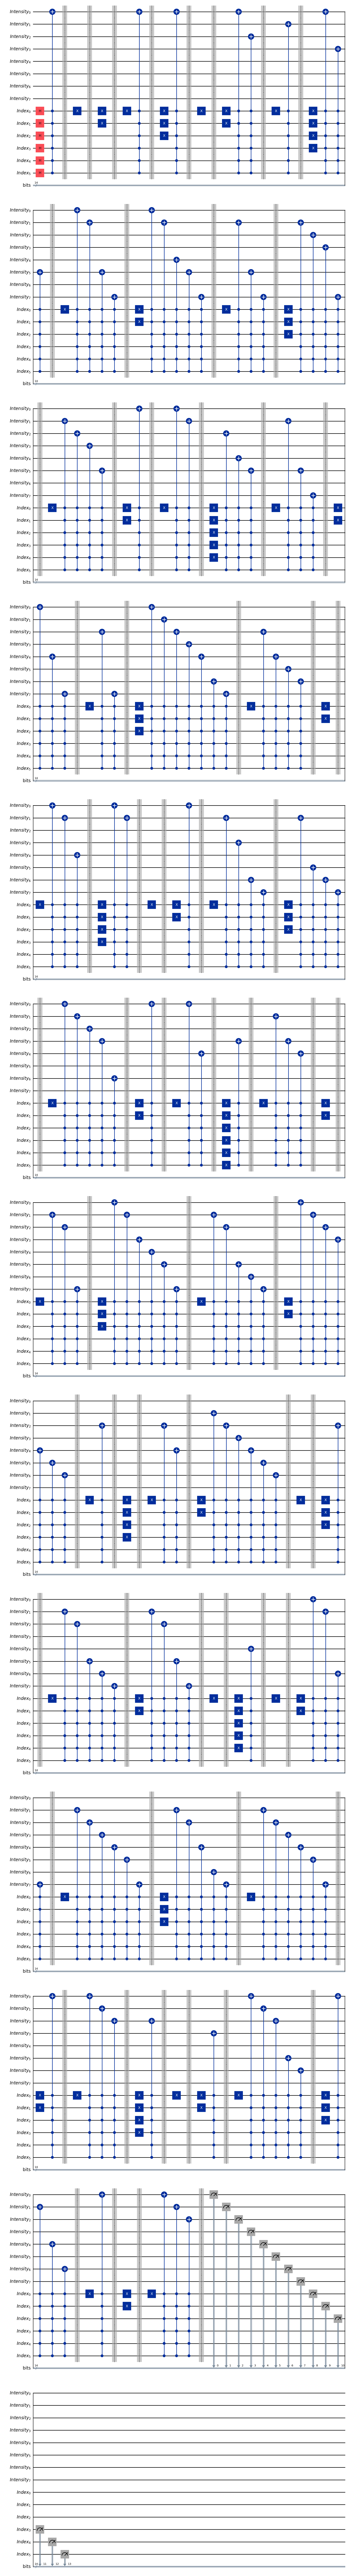

In [56]:
construct_neqr(neqr_circuit,  image)
neqr_circuit.draw(output='mpl')

In [57]:
simulator = qiskit_aer.AerSimulator()
circuit = qiskit.transpile(neqr_circuit, simulator)
shots = 1000
result = simulator.run(circuit, shots=shots).result()

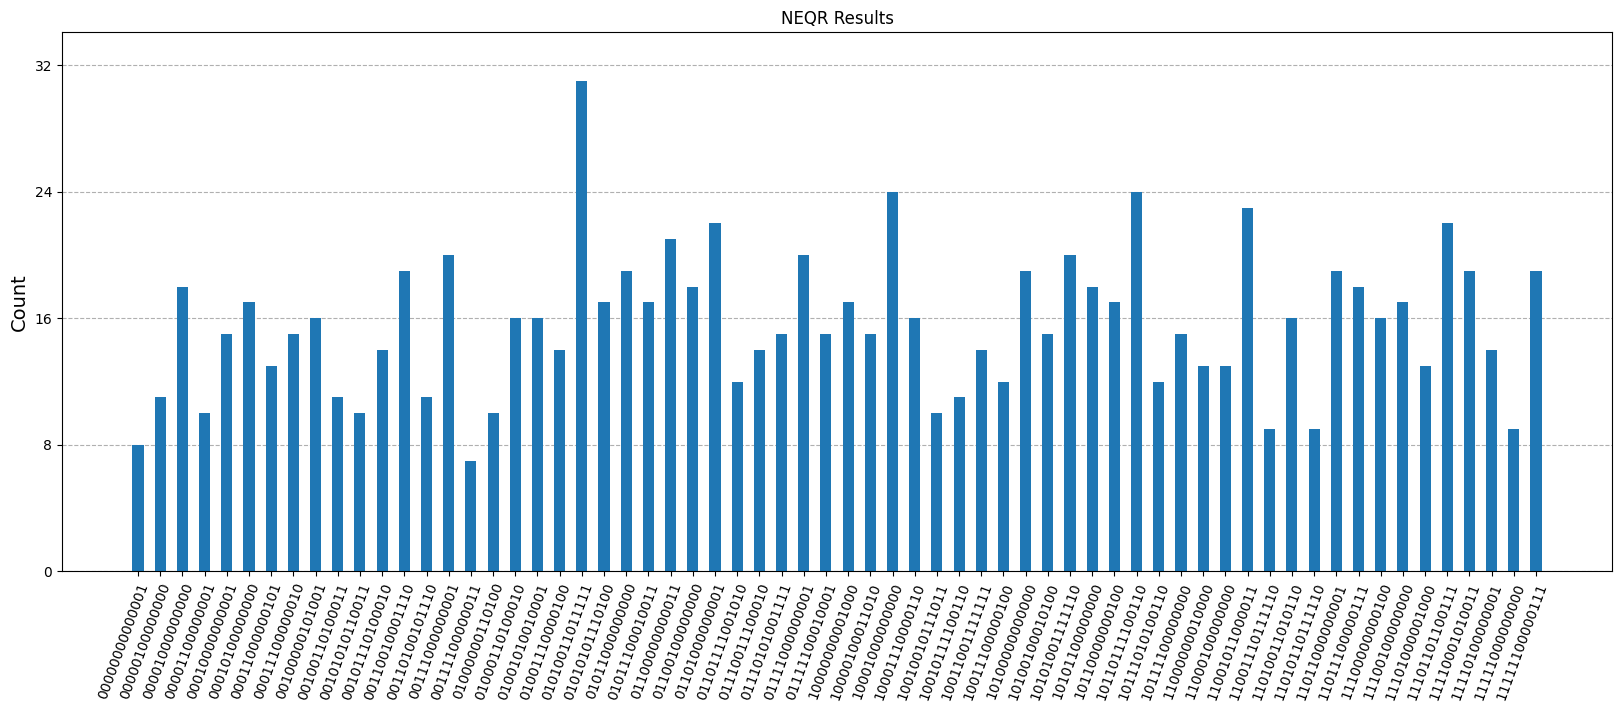

In [58]:
counts = result.get_counts(circuit)
qiskit.visualization.plot_histogram(counts, figsize=(20, 7), title="NEQR Results", bar_labels=False)

In [59]:
x = int(np.ceil(log(image.shape[1],2)))
y = int(np.ceil(log(image.shape[0],2)))

out_pixels = []
for item in counts:
    item = item.zfill(x + y)
    out_pixels.append((int(item[0:x+y], 2), int(item[x+y:],2)))

out_image = np.zeros((1, len(flat_ang_rep)))

for pixel in out_pixels:
    out_image[0][pixel[0]] = pixel[1]

out_image = np.array(out_image).reshape(image.shape)

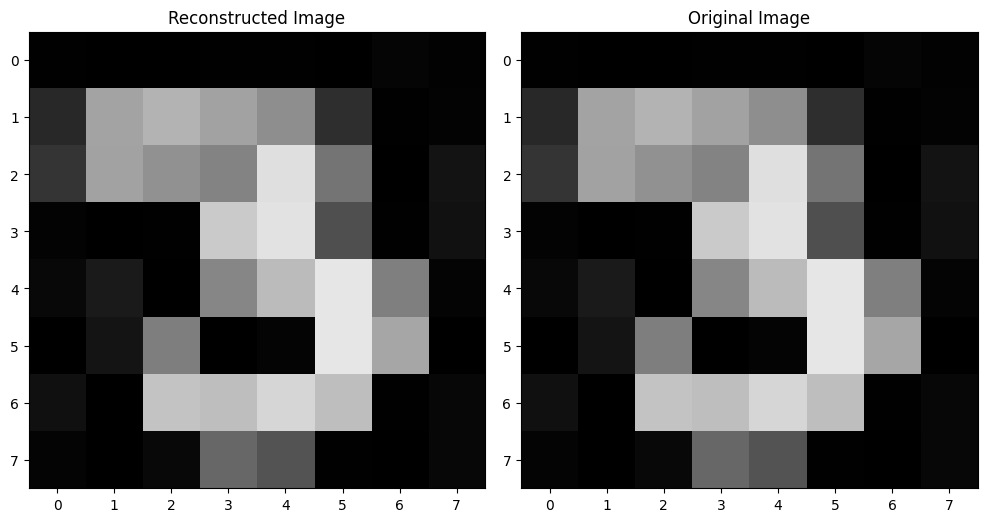

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(out_image, cmap='gray', vmin=0, vmax=255)
axs[0].set_title('Reconstructed Image')
axs[1].imshow(image, cmap='gray', vmin=0, vmax=255)
axs[1].set_title('Original Image')

plt.tight_layout()